In [ ]:
!pip install pytesseract
!apt install tesseract-ocr

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 1s (4,035 kB/s)
Selecting previously unselected package tesseract-ocr-eng.
(Reading database ... 121752 files and directories currently installed.)
Preparing to unpack .../tesseract-ocr-

In [ ]:
# prompt: mount google drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#ddetect and correct rotations in image

import argparse
import imutils
import cv2
import pytesseract
from pytesseract import Output
# from google.colab.patches import cv2_imshow
import numpy as np
# construct the argument parser and parse the arguments

def rotate(img):

		image = img
		rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
		results = pytesseract.image_to_osd(rgb, output_type=Output.DICT)
		# display the orientation information
		print("[INFO] detected orientation: {}".format(
			results["orientation"]))
		print("[INFO] rotate by {} degrees to correct".format(
			results["rotate"]))
		print("[INFO] detected script: {}".format(results["script"]))


		rotated = imutils.rotate_bound(image, angle=results["rotate"])
		# cv2_imshow(rotated)
		return rotated

In [ ]:
from matplotlib import pyplot as plt


def get_table(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


    # Invert the image
    thresh = cv2.bitwise_not(thresh)


    # Convert the image to the appropriate format
    thresh = thresh.astype(np.uint8)


    # Find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)


    # Find the largest contour
    max_area = 0
    largest_contour = None
    for contour in contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            largest_contour = contour


    # Find the bounding rectangle of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)


    # Crop the image to the bounding rectangle
    cropped = img[y:y+h, x:x+w]


    # Save the cropped image
    cv2.imwrite('cropped.png', cropped)


    # Get the bounding box for each cell
    cell_boxes = []
    # convert to grayscale
    gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
    # apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,  11, 2 )
    # thresh = cv2.adaptiveThreshold(gray
    # # invert the image
    # thresh = cv2.bitwise_not(thresh)
    # find contours
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # sort the contours left-to-right
    contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])
    # iterate over each contour
    for contour in contours:
        # get bounding box for each contour
        x, y, w, h = cv2.boundingRect(contour)
        # append the bounding box to the list
        cell_boxes.append((x, y, w, h))

    def filter_boxes(boxes, threshold=0.5):
      # Find the median height and width of the boxes
      heights = [h for _, _, _, h in boxes]
      widths = [w for _, _, w, _ in boxes]
      median_height = np.median(heights)
      median_width = np.median(widths)


      # Filter the boxes based on the height and width
      filtered_boxes = []
      for box in boxes:
          x, y, w, h = box
          if h > threshold * median_height and w > threshold * median_width:
              filtered_boxes.append(box)


      return filtered_boxes

    # Filter the boxes
    # cell_boxes = filter_boxes(cell_boxes,0.2)
    cell_boxes = [box for box in cell_boxes if 20_00_000 >box[2]*box[3] > 300]
    areas = [box[2]*box[3] for box in cell_boxes if box[2]*box[3] <1_000]
    plt.hist(areas, bins=25)
    plt.show()

    return cell_boxes


In [ ]:
def draw_boxes(img, cell_boxes):

    # Draw bounding boxes on the image
    for x, y, w, h in cell_boxes:
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)


    # Save the image with bounding boxes
    plt.imshow(img)
    cv2.imwrite('table_with_boxes.png', img)
    # show the image


[INFO] detected orientation: 0
[INFO] rotate by 0 degrees to correct
[INFO] detected script: Arabic


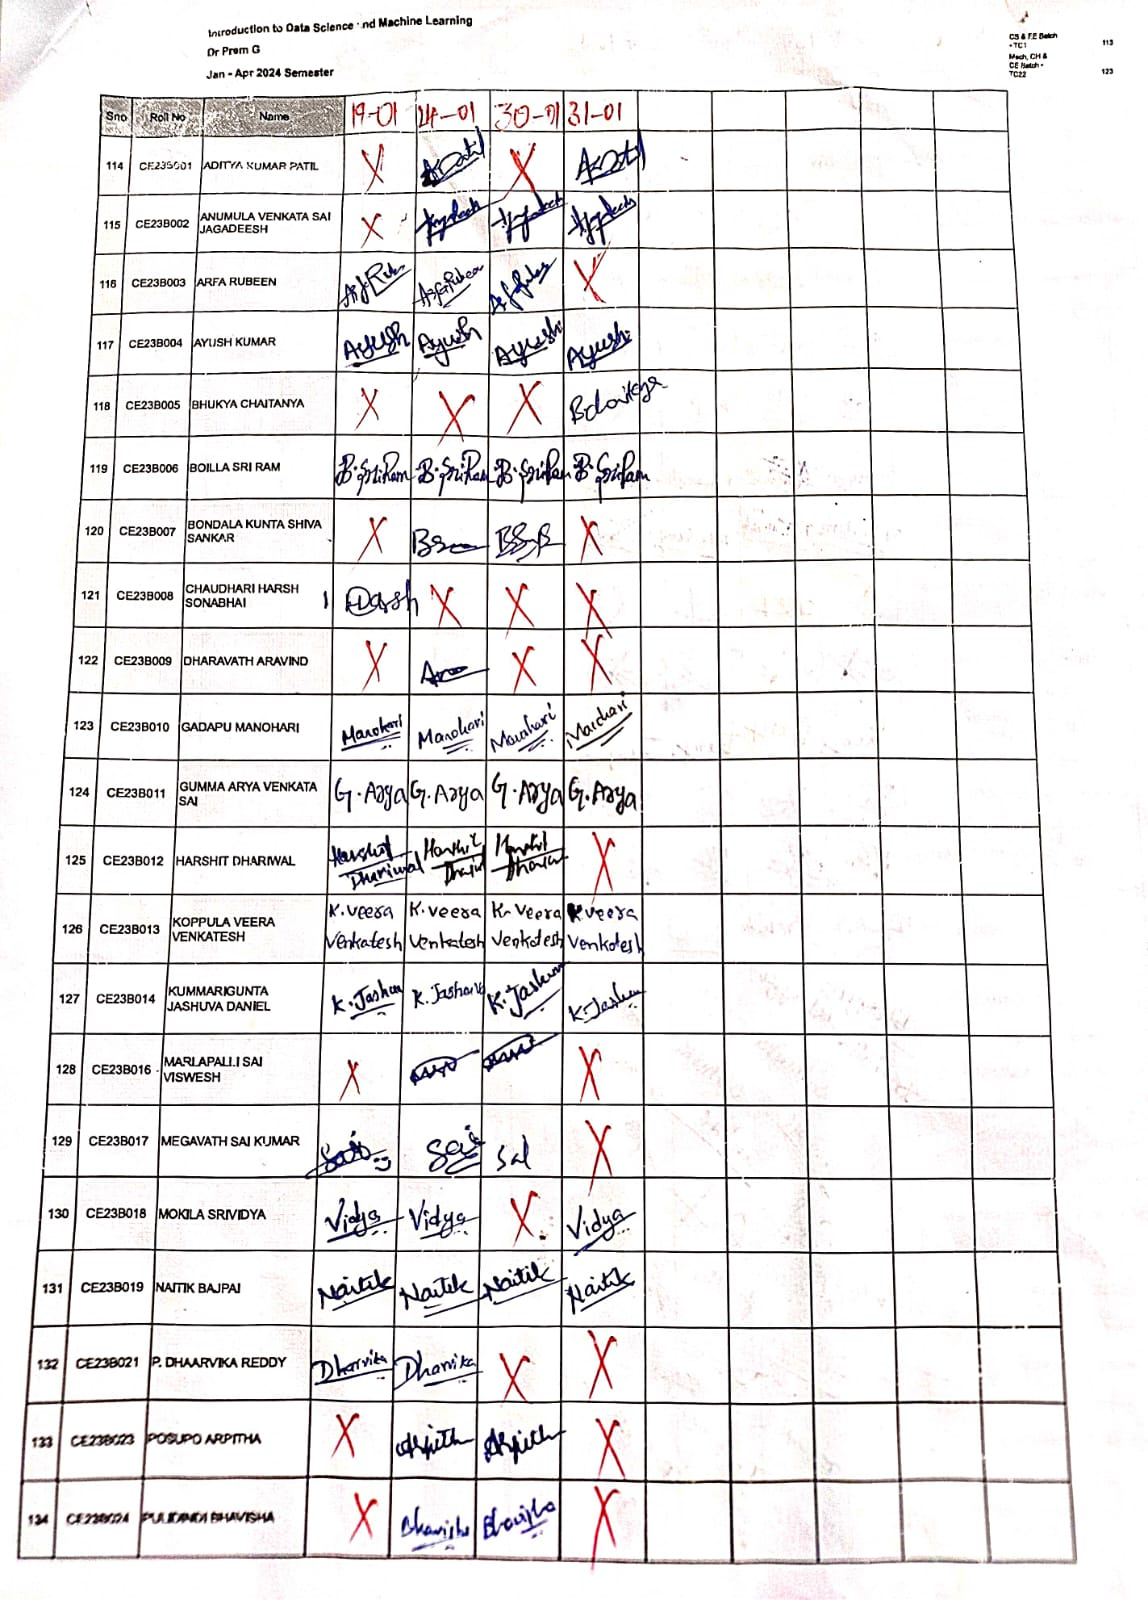

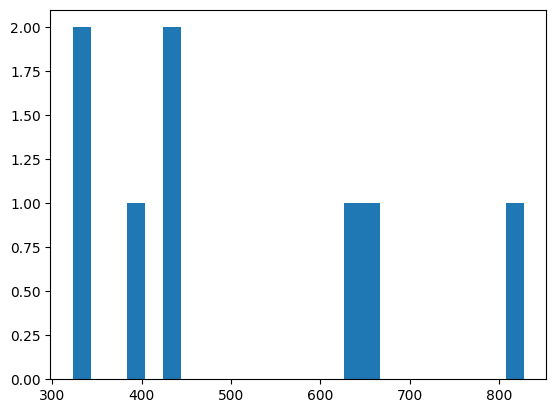

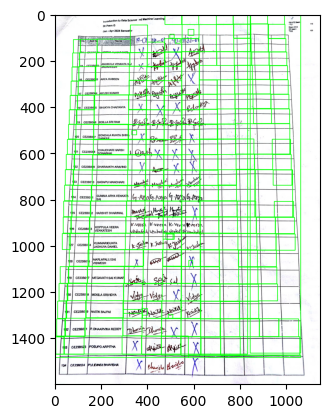

In [ ]:
#execute pipeline

img= cv2.imread('/content/drive/MyDrive/Hackathon_Dataset/Hackathon_Dataset/020.jpg')
img= rotate(img)
cell_boxes = get_table(img)
draw_boxes(img, cell_boxes)
#divide into cells
#for each cell:
# print(perform_ocr(img))

In [ ]:
# Store the cropped boxes of predicted cells in a 2d list
def get_table_matrix(img, cell_boxes):
    table = [] # 2d list to store the cropped cell images
    # img = cv2.imread(img_path)
    # cell_boxes = sorted(cell_boxes)
    # sort in transposed order
    cell_boxes = sorted(cell_boxes, key=lambda box: (box[1]//3, box[0]//3))
    # Now, we see when the row changes
    row = []
    prev_y = cell_boxes[0][1]
    for box in cell_boxes:
        x, y, w, h = box
        if y - prev_y > 50:
            table.append(row)
            row = []
        cell = img[y:y+h, x:x+w]
        row.append(cell)
        prev_y = y
    return table




table = get_table_matrix(img, cell_boxes)
table_text= [[perform_ocr( Image.fromarray(img)) for img in row] for row in table]

In [ ]:
# !pip install python-docx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.6/239.6 kB 2.6 MB/s eta 0:00:00


In [ ]:
for row in table_text:
  print(row)

["uroducton to Oata Sclence ‘nd Machine Learning Or Prem G Jan = Apr 2024 Semestpr [ANUMULA VENKATA Sit qi leva nuacen Y cez35004 [ayusH KUMAR. 18 | CE2380)5 |aHUKYA CHAITANYA r 19 | cezsB0h6 [BOLLASRIRAM 4 . 5, Cyt 0 | cezapoty [BONDALA KUNTA S! Lf) | cezapoqe [CHAUOHARI HARSH CE2380¢9 [OHARAVATH ARAVIND 33 | CE2360}0 |GADAPU MANOHARI cle! y 3 4 | CE23B0) nee AER ENS Gs AI f . tps} cezse0)2 fuarsuir onannva, | [ems I eza80}3 |OPPULA VERA K. Vee Wo a] K- Vee aleve 8 | cE2sB0}} |MARAPALLISAL CE23B0'7 |MEGAVATH SAI KUI > CE23B0|8 |MOKILA SRIVIDYA Ni : Vid, 1] CE2380}9 |NATIK BAIPAL 5 ; ", '', '', '', '', '', '', '', '', '', '', 'Hf f-0 wi ', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', 'JANUMULA VENKATA ', '', '', '']
['', '', '', '', '', 'ARFA RUBEEN .vUSH KUMAR. ', '', '', '', '']
['', '', '', '', '', '', '', 'CE238 ', '', '']
['', '', '', '', '', 'IsHUKYA CHAITANYA |BOILLA SRI RAM. ', '', '', '', '', '', '']
['', '', '', '', '', '', '', 'CE23

In [ ]:
import docx, os
from docx.shared import Inches
from PIL import Image


def generate_docx(table:list[list[np.ndarray]]): # table is an array of images in form of np.ndarray
    doc = docx.Document()
    table_data = table
    num_rows = len(table_data)
    num_cols = min(max(len(row) for row in table_data),7)


    # Create a table in the document
    doc_table = doc.add_table(rows=num_rows, cols=num_cols)


    # Set table style (this style includes borders)
    doc_table.style = 'Table Grid'


    # Iterate over the data and add it to the table
    for i, row in enumerate(table_data):
        for j, cell in enumerate(row):
            # # Save the ndarray image to a file using PIL
            # filename = f"temp_img_{i}_{j}.png"
            # img = Image.fromarray(cell)
            # img.save(filename)


            # # Add the image to the cell
            # # doc_table.cell(i, j).paragraphs[0].add_run().add_picture(filename, width=Inches(1.0))
            # text=perform_ocr(img)
            doc_table.cell(i, j).text= table[i][j]




            # Remove the temporary image file
            # os.remove(filename)
            # if j >4:
            #     break
        if i > 6:
            break


    # Save the document
    doc.save("table.docx")


generate_docx(table_text)


In [ ]:

from PIL import Image, ImageDraw
def perform_ocr(img):
    # img = Image.fromarray(img)
    # Convert the image to grayscale

    # gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Apply image preprocessing techniques (optional)
    # gray = cv2.bilateralFilter(gray, 9, 75, 75)  # Reduce noise
    # gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)  # Improve contrast

    # Set Tesseract configuration options
    # config = '--psm 3 --oem 3 -c tessedit_char_whitelist=0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'

    draw = ImageDraw.Draw(img)
    data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DICT)

    ocrtext=""
    # Iterate over the bounding boxes and text
    for i, word in enumerate(data['text']):
        if word.strip():
            x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
            ocrtext+=word+" "
            # print(f"Text: {ocrtext}, Bounding Box: ({x}, {y}, {x+w}, {y+h})")

    return ocrtext
    # Use Tesseract OCR to extract text from the image
    # text = pytesseract.image_to_string(gray, config=config)

    # Get additional OCR data
    # data = pytesseract.image_to_data(gray, config=config, output_type=Output.DICT)
    # print(text)
    # cleaned_string = ''
    # for char in ocrtext:
    #     if char.isalnum() or char=' ':
    #         cleaned_string += char
    # return cleaned_string

## Extraas

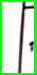

AttributeError: 'numpy.ndarray' object has no attribute 'load'

In [ ]:
cell_texts = []

    # Iterate through the cell boxes
for x, y, w, h in cell_boxes:
    # Crop the cell region from the image
    if w<500 and h<500:
      cropped_image = img[y:y+h, x:x+w]
      # cv2_imshow(cropped_image)
      # Perform OCR on the cropped cell
      cell_text = perform_ocr(cropped_image)
      print(cell_text)
      cell_texts.append(cell_text)

print(cell_texts)

In [ ]:
#bb using tesseract

from PIL import Image, ImageDraw
import pytesseract

# Open the image
image = Image.open('/content/drive/MyDrive/Hackathon_Dataset/Hackathon_Dataset/043.jpg')

draw = ImageDraw.Draw(image)

# Extract bounding boxes and text
data = pytesseract.image_to_data(image, output_type=pytesseract.Output.DICT)

# Iterate over the bounding boxes and text
for i, word in enumerate(data['text']):
    if word.strip():
        x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
        print(f"Text: {word}, Bounding Box: ({x}, {y}, {x+w}, {y+h})")
        draw.rectangle((x, y, x+w, y+h), outline='red', width=2)

image.save('image_with_boxes.png')